In [1]:
using Statistics
using Plots
using BenchmarkTools
using Profile
using FFTW
using Statistics
using Optim
using Images, FileIO, ImageIO
using Printf
using Revise
using Profile
using LinearAlgebra
using Random
using Distributions
using FITSIO
using SparseArrays

In [2]:
push!(LOAD_PATH, pwd()*"/../../../main")
using DHC_2DUtils
push!(LOAD_PATH, pwd()*"/../../")
using Deriv_Utils_New
using Data_Utils
using Visualization
using ReconFuncs

### Why don't reg im S based images work better?

In [63]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/1000_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
3830.952426245689
Init269.1009695044303
0.0
Recon117.71091621771856
47.246177184049394


The true image actually has a worse loss than BOTH the reconstructed image and the initial image, simply because lambda is too high to even let the init get to the true image.
**NEED TO CHANGE THE LOSS FUNCTION OR AT LEAST LAMBDA FOR THE REG CASE** <br/>
For the regular case with no log coeffs, you can't use the expected chisquare value for l1true. It should instead be 1 since that distribution peaked near 1.

In [64]:
experiment = load("../../StandardizedExp/Nx64/Data_1000.jld2")

Dict{String,Any} with 5 entries:
  "true_img"    => [0.00765177 0.00730492 … 0.0226818 0.0233494; 0.00726517 0.0…
  "init"        => [0.011148 0.000226939 … 0.025887 0.030695; 0.00735475 0.0121…
  "noise model" => "White noise, No smoothing. sigma=std(true_img)"
  "seed"        => 41
  "std"         => 0.00917997

In [65]:
sum((experiment["true_img"] - experiment["init"]).^2) #Close to expected Nx^2(sigma)^2

0.32906514987514457

In [66]:
sum((alinit - altrue).^2) #Close to expected Nx^2(sigma)^2*<A^2>

0.1784833145663735

In [67]:
Nx=64
wn_exp = mean(wind_2d(Nx).^2)*Nx*Nx*(0.009)^2

0.1737496143069305

In [68]:
round(0.009, sigdigits=3)

0.009

_Given noise model I have an estimate for the without lambda L2true._

In [69]:

chisq = Distributions.Chisq(length(s_targ_mean))
println("Ideal Lambda should be less than ", (l1init - 1.0)./wn_exp)

Ideal Lambda should be less than 1543.0305878597642


In [70]:
lam_prop = minimum([gttarget["dict"]["lambda"], (l1init - 1.0)./wn_exp])

1543.0305878597642

In [71]:
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*lam_prop*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)
l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*lam_prop*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*lam_prop*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)

True0.2792624951944618
137.70260689925527
Init269.1009695044303
0.0
Recon117.71091621771856
1.6982517766850689


In [72]:
kbins = convert(Array{Float64}, collect(1:32))

32-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 21.0
 22.0
 23.0
 24.0
 25.0
 26.0
 27.0
 28.0
 29.0
 30.0
 31.0
 32.0

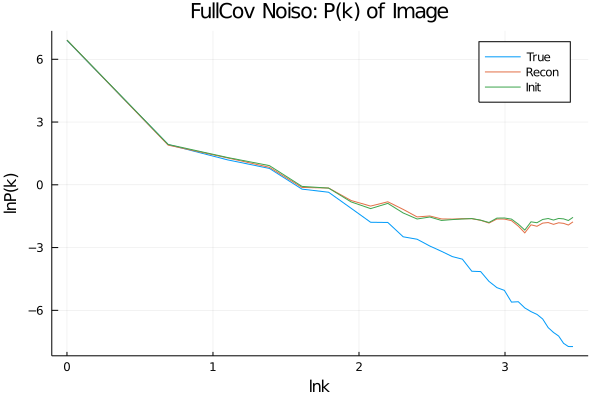

In [73]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

### Using the "Correct" Lambda

In [74]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
115.48038402999249
Init269.1009695044303
0.0
Recon8.303597614720935
19.873282835880374


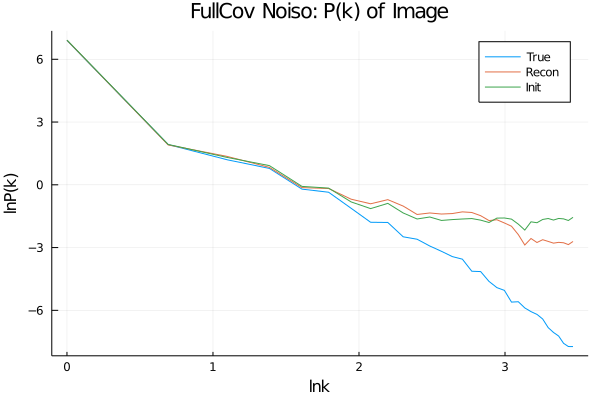

In [75]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

L1true>L1recon, but L1recon is a bit too large

In [76]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_0-001_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
0.11548038402999249
Init269.1009695044303
0.0
Recon0.08742843539164658
0.07810493284902127


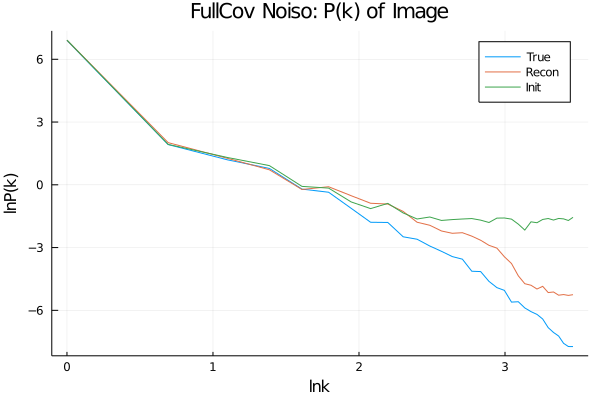

In [77]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

But now L1recon<L1true: we want L1true to be only slightly larger. The constraint is so relaxed it just makes an image that's more like the SFD targ mean than the true im.

In [78]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_0-01_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
1.1548038402999252
Init269.1009695044303
0.0
Recon0.16792650399436093
0.5863955516203473


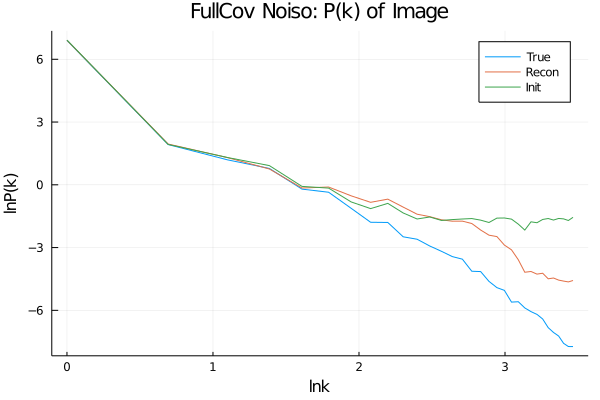

In [79]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

#### Diag Cov was way worse

### LogCoeff:
Does well on the power spectrum but BAD artefacts in some images. The recon Loss1 is closer to the target than the image itself and the image looks more dusty (when no artefacts) but it looks less like the actual true image. Increasing lambda to make Loss1recon<Loss1true doesn't help because you end up depressing the power spectrum.

In [80]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.0008924165728318676
Init388.091139523465
0.0
Recon7.491648845931981
0.004156834933837604


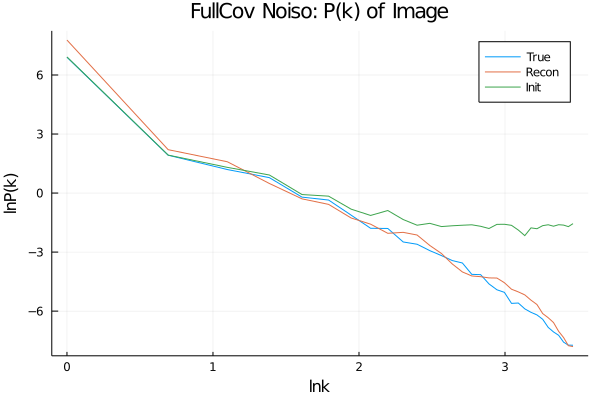

In [81]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [82]:
reshape(gttarget["coeff_mask"][3+34:end], (34, 34))

34×34 BitArray{2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  1     1 

Moving closer to the target than I want to. L1recon < L1true. 
**Let's increase Lambda to fix this?**

In [83]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_1-0_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.08924165728318675
Init388.091139523465
0.0
Recon6.279469031823527
0.2999873710540242


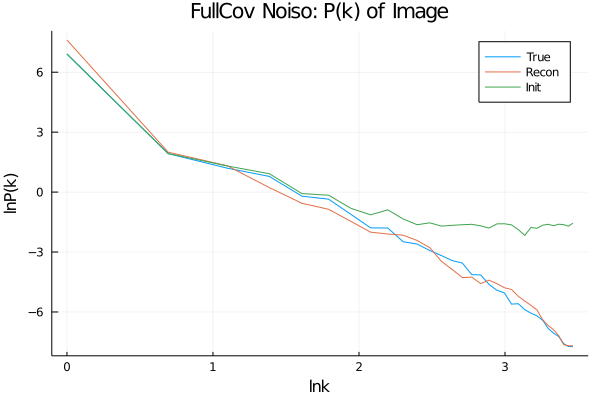

In [84]:
kbins= convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [24]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_10_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.8924165728318676
Init388.091139523465
0.0
Recon7.196722678076889
1.1711584235470576


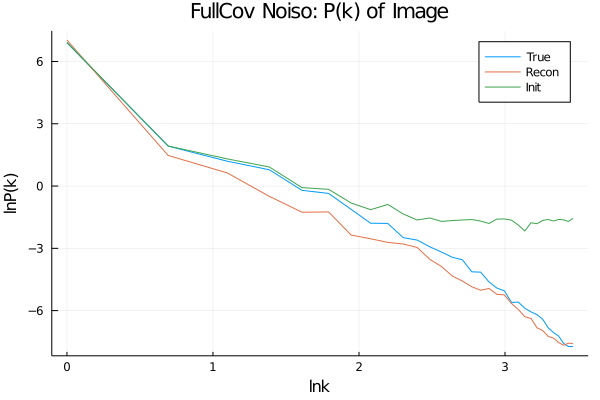

In [25]:
kbins= convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [88]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...))
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...))
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...))
s_smooth = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...))


1192-element Array{Float64,1}:
  -3.144031877784822
 -10.936546358015779
  -7.175948729949612
  -6.912069606541453
  -5.762511716584831
  -6.473896463693209
  -7.078632506472145
  -6.508813780032913
  -6.249305700008489
  -6.489125133947129
  -7.28006147739092
  -6.231527617295995
  -6.098724517252059
   ⋮
  -6.744409380148002
  -7.069597157118807
  -7.194831270753814
  -6.914446623549263
  -7.1622296921050195
  -7.55984535041072
  -7.280098569358903
  -7.075231305945022
  -6.946044616955598
  -7.293234714166373
  -2.855862523646302
  -6.88024988022421

In [89]:
function J_hashindices(J_values, fhash)
    jindlist = []
    for jval in J_values
        push!(jindlist, findall(fhash["J_L"][:, 1].==jval))
    end
    return vcat(jindlist'...)
end

function J_S1indices(J_values, fhash)
    #Assumes this is applied to an object of length 2+Nf+Nf^2 or 2+Nf
    return J_hashindices(J_values, fhash) .+ 2
end

Jfiltidx = J_hashindices([0, 1, 2, 3], filter_hash)
JS1ind = J_S1indices([0, 1, 2, 3], filter_hash)

4×8 Array{Int64,2}:
 3   7  11  15  19  23  27  31
 4   8  12  16  20  24  28  32
 5   9  13  17  21  25  29  33
 6  10  14  18  22  26  30  34

In [90]:
struesel = s_true[JS1ind]
sinitsel = s_init[JS1ind]
sreconsel = s_recon[JS1ind]
ssmoothsel = s_smooth[JS1ind]

4×8 Array{Float64,2}:
 -7.17595  -7.07863  -7.28006  -7.02093  …  -6.93401  -6.84187  -7.04626
 -6.91207  -6.50881  -6.23153  -6.21364     -6.11336  -6.26006  -6.6376
 -5.76251  -6.24931  -6.09872  -5.90779     -5.74751  -6.61686  -5.99643
 -6.4739   -6.48913  -6.57186  -6.18528     -6.43252  -7.44696  -6.82477

In [100]:
#sfdall = readsfd_fromsrc("../../data/dust10000.fits", 64, logbool=false)
#dbn = get_dbn_coeffs(sfdall, filter_hash, dhc_args, coeff_mask=nothing)
dbnfile = load("../../SavedCovMats/reg_apd_noiso_nologcoeff.jld2")
dbn = dbnfile["dbncoeffs"]

10000×1192 Array{Float64,2}:
 0.0361376  9.04943e-6   0.000514045  0.00113941   …  0.0313476   0.000457062
 0.289418   0.00257863   0.0574735    0.274282        1.69589     0.0211946
 0.0506923  5.60371e-5   0.00152274   0.00294826      0.0743567   0.00169278
 0.0341559  2.58829e-5   0.000478117  0.00128632      0.0303609   0.000482999
 0.170677   0.000401088  0.0147206    0.0210937       0.790839    0.0137406
 0.120943   0.000501101  0.00548136   0.0124099    …  0.336582    0.00456656
 0.063558   8.47624e-5   0.00169041   0.00435979      0.0845048   0.0010539
 0.192367   0.00153715   0.0379013    0.11789         1.07505     0.019009
 0.0707273  9.83063e-5   0.00226754   0.01116         0.128587    0.00240479
 0.125574   0.000264443  0.00531572   0.0112585       0.296421    0.00336588
 0.0656378  0.000475194  0.00244057   0.0096468    …  0.139068    0.0030072
 0.0421977  0.000125084  0.000934353  0.00418621      0.0541982   0.000994211
 0.0386173  3.68446e-5   0.000589672  0.00215856  

In [101]:
logdbn = log.(dbn)

10000×1192 Array{Float64,2}:
 -3.32042  -11.6128   -7.5732   -6.77724  …  -7.56084  -3.46262    -7.69069
 -1.23988   -5.9605   -2.85643  -1.2936      -3.01588   0.528205   -3.85401
 -2.98198   -9.7895   -6.48725  -5.82654     -5.85918  -2.59888    -6.38139
 -3.37682  -10.5619   -7.64565  -6.65597     -6.86559  -3.4946     -7.6355
 -1.76798   -7.82133  -4.21851  -3.85878     -4.24888  -0.234661   -4.2874
 -2.11243   -7.5987   -5.2064   -4.38926  …  -4.68458  -1.08891    -5.389
 -2.7558    -9.37566  -6.38278  -5.43533     -6.06498  -2.47095    -6.85526
 -1.64835   -6.47782  -3.27277  -2.138       -3.1035    0.0723635  -3.96284
 -2.64892   -9.22742  -6.08906  -4.49542     -5.73363  -2.05115    -6.03029
 -2.07486   -8.23788  -5.23709  -4.48663     -5.22627  -1.21597    -5.69407
 -2.7236    -7.65179  -6.01552  -4.64113  …  -4.57937  -1.97279    -5.80675
 -3.16539   -8.98653  -6.97566  -5.47596     -6.49233  -2.91511    -6.91356
 -3.25405  -10.2088   -7.43594  -6.13831     -7.29636  -3.15978

In [102]:
dbnmean = mean(logdbn, dims=1)[:]
meansel = dbnmean[JS1ind]

4×8 Array{Float64,2}:
 -6.42919  -6.43257  -6.4332   -6.43553  …  -6.42785  -6.42342  -6.42898
 -5.47914  -5.48496  -5.48807  -5.48096     -5.4838   -5.47847  -5.48803
 -4.92615  -4.91499  -4.81094  -4.89698     -4.90936  -4.80682  -4.90819
 -4.70309  -4.38459  -4.20983  -4.3771      -4.37379  -4.20383  -4.37804

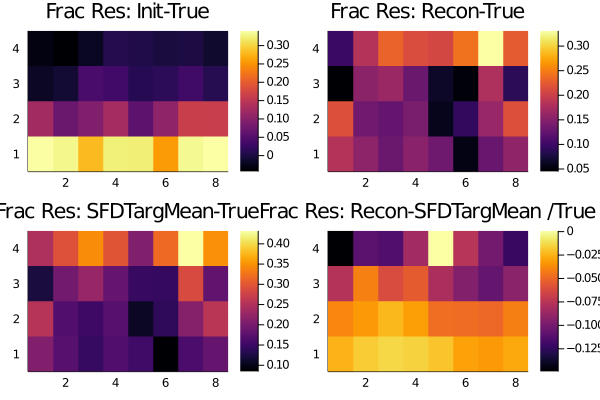

In [103]:
p = plot(heatmap((sinitsel .- struesel)./abs.(struesel), title="Frac Res: Init-True"),
heatmap((sreconsel .- struesel)./abs.(struesel), title="Frac Res: Recon-True"),
heatmap((meansel .- struesel)./abs.(struesel), title="Frac Res: SFDTargMean-True"),
heatmap((sreconsel .- meansel)./abs.(struesel), title="Frac Res: Recon-SFDTargMean /True"))

**Z scores**

In [104]:
siglog = std(logdbn, dims=1)

1×1192 Array{Float64,2}:
 0.949927  2.30556  2.07413  2.19625  …  2.00988  2.03672  1.8015  1.85022

In [105]:
using StatsBase
function distribution_percentiles(dbn, idx, perc)
    idxperc = zeros(size(idx))
    idxperc .= (x-> percentile(dbn[:, x], perc)).(idx)
    return idxperc
end
sfdmed = distribution_percentiles(logdbn, JS1ind, 50)

4×8 Array{Float64,2}:
 -6.77221  -6.76932  -6.75457  -6.75869  …  -6.7727   -6.77955  -6.75449
 -5.73415  -5.73216  -5.75423  -5.75359     -5.76196  -5.74358  -5.75352
 -5.13945  -5.13592  -5.05006  -5.14373     -5.13894  -5.05793  -5.15853
 -4.97716  -4.66031  -4.50308  -4.64103     -4.65338  -4.47231  -4.65732

In [106]:
sigsel = (siglog[:])[JS1ind]

4×8 Array{Float64,2}:
 2.07413  2.06649  2.06147  2.06964  2.07433  2.07653  2.07849  2.07927
 2.19625  2.19132  2.18287  2.18812  2.19798  2.20345  2.19756  2.1992
 2.28164  2.26975  2.28846  2.2841   2.30245  2.30302  2.30323  2.29122
 2.36736  2.36627  2.3992   2.37283  2.37456  2.37803  2.40817  2.3748

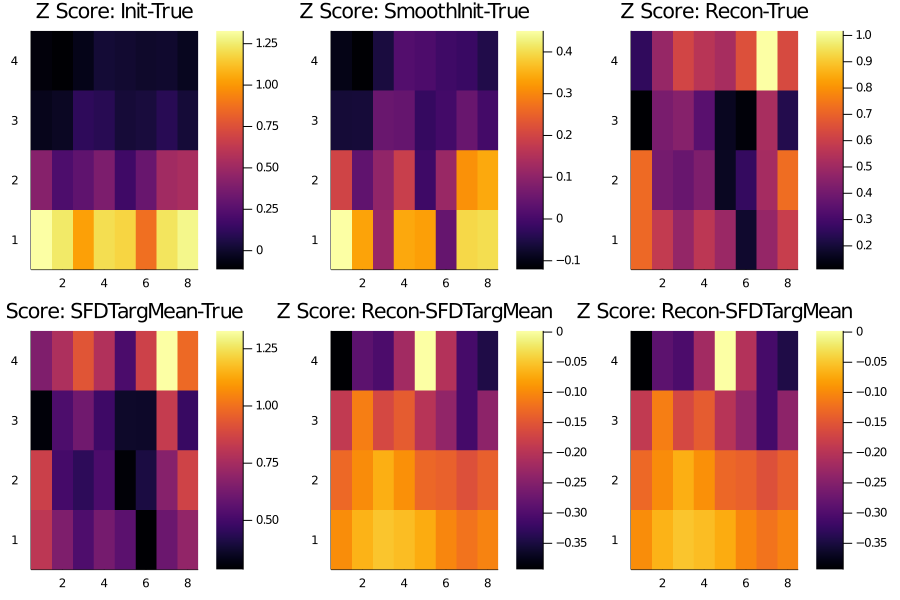

In [107]:
p = plot(heatmap((sinitsel .- struesel)./sigsel, title="Z Score: Init-True"),
heatmap((ssmoothsel .- struesel)./sigsel, title="Z Score: SmoothInit-True"),
heatmap((sreconsel .- struesel)./sigsel, title="Z Score: Recon-True"),
heatmap((meansel .- struesel)./sigsel, title="Z Score: SFDTargMean-True"),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean"),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean"), size=(900, 600))

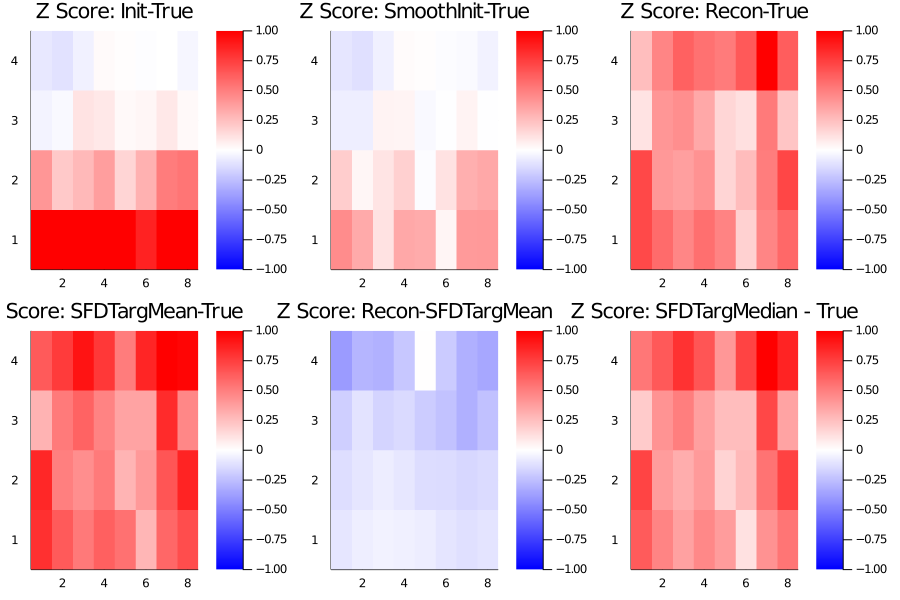

In [108]:
clims=(-1.0, 1.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap((sinitsel .- struesel)./sigsel, title="Z Score: Init-True", clims=clims, c=cg),
heatmap((ssmoothsel .- struesel)./sigsel, title="Z Score: SmoothInit-True", clims=clims, c=cg),
heatmap((sreconsel .- struesel)./sigsel, title="Z Score: Recon-True", clims=clims, c=cg),
heatmap((meansel .- struesel)./sigsel, title="Z Score: SFDTargMean-True", clims=clims, c=cg),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean", clims=clims, c=cg),
heatmap((sfdmed .- struesel)./sigsel, title="Z Score: SFDTargMedian - True", clims=clims, c=cg), size=(900, 600))

In [113]:
(meansel .- struesel)./sigsel

4×8 Array{Float64,2}:
 0.810459  0.646551  0.523929  0.622939  …  0.284921  0.59706   0.698659
 0.848908  0.501952  0.444848  0.519763     0.401349  0.668263  0.863645
 0.299045  0.522264  0.610942  0.484358     0.35917   0.831989  0.470482
 0.648994  0.768188  0.924653  0.778599     0.855594  1.32819   0.980589

In [114]:
(sinitsel .- struesel)./sigsel

4×8 Array{Float64,2}:
  1.32745     1.24127     1.02427    1.20667    …  1.22691       1.2895
  0.41291     0.213377    0.275576   0.378914      0.512414      0.539896
 -0.0460657  -0.0251941   0.109851   0.0884818     0.0914122     0.0228559
 -0.0883822  -0.114344   -0.0543885  0.0188305     0.000150609  -0.0352962

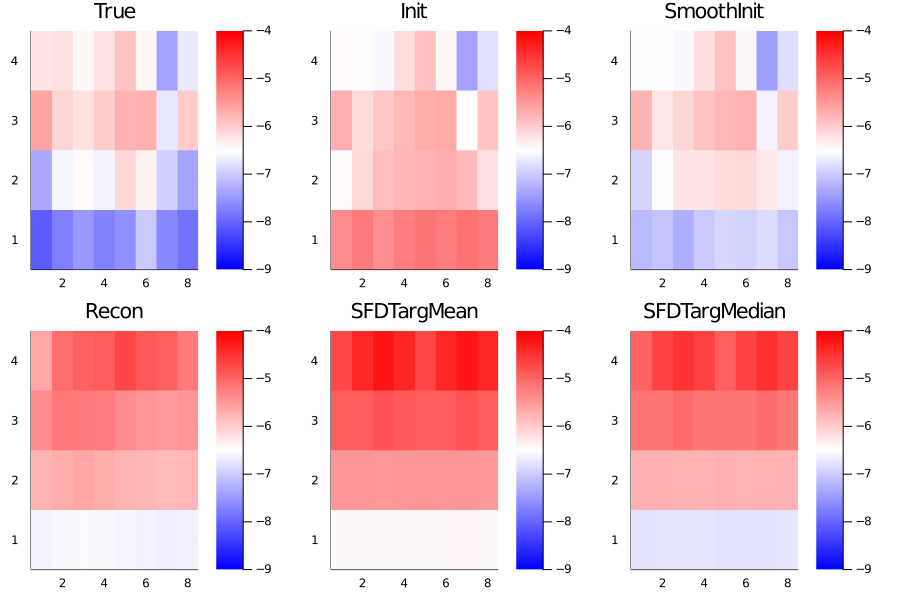

In [109]:
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap(struesel, title="True", clims=clims, c=cg),
heatmap(sinitsel, title="Init", clims=clims, c=cg),
heatmap(ssmoothsel, title="SmoothInit", clims=clims, c=cg),
heatmap(sreconsel, title="Recon", clims=clims, c=cg),
heatmap(meansel, title="SFDTargMean", clims=clims, c=cg),
heatmap(sfdmed, title="SFDTargMedian", clims=clims, c=cg), size=(900, 600))

In [110]:
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)
s_smooth = DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...)
dbnmean = mean(dbn, dims=1)[:]
cmeansel = dbnmean[JS1ind]
initsel = s_init[JS1ind]
truesel = s_true[JS1ind]
reconsel = s_recon[JS1ind]
smoothsel = s_smooth[JS1ind]
csigsel = std(dbn, dims=1)[:][JS1ind]

4×8 Array{Float64,2}:
  8.23288   7.56094   8.08922   8.09219  …   9.45883   9.71525   9.37592
 12.7806   12.3623   12.6216   12.1611      13.9169   13.8013   13.6181
  8.13033   8.58452   9.31466   8.34802      9.05133   9.17479   8.73189
  4.77279   4.67166   5.12326   5.10969      5.97998   6.38323   5.49112

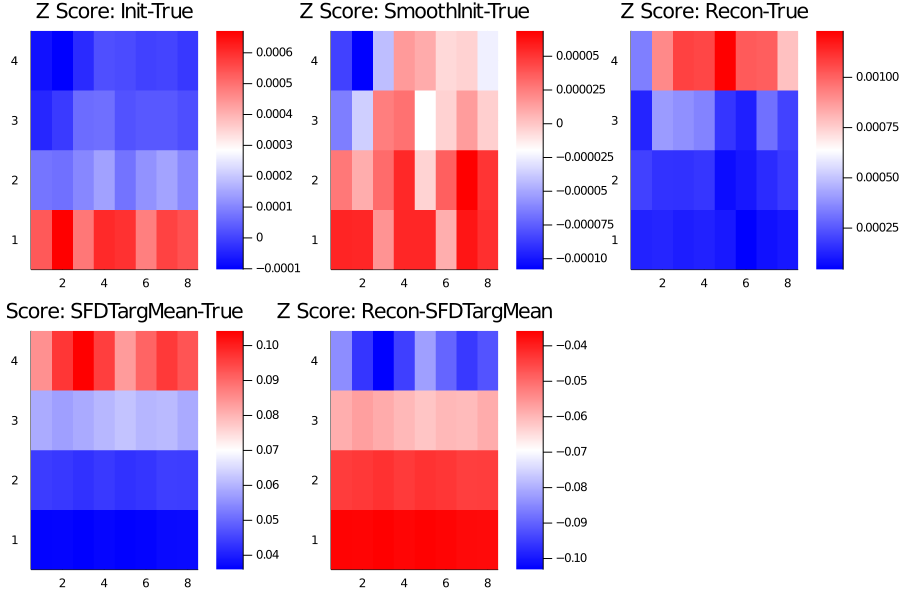

In [112]:
cg = cgrad([:blue, :white, :red])
p = plot(heatmap((initsel .- truesel)./csigsel, title="Z Score: Init-True", c=cg),
heatmap((smoothsel .- truesel)./csigsel, title="Z Score: SmoothInit-True", c=cg),
heatmap((reconsel .- truesel)./csigsel, title="Z Score: Recon-True", c=cg),
heatmap((cmeansel .- truesel)./csigsel, title="Z Score: SFDTargMean-True", c=cg),
heatmap((reconsel .- cmeansel)./csigsel, title="Z Score: Recon-SFDTargMean", c=cg), size=(900, 600))

In [115]:
(meansel .- struesel)

4×8 Array{Float64,2}:
 1.681     1.33609  1.08006   1.28926  1.15725   0.591645  1.24098  1.4527
 1.86441   1.09994  0.971045  1.1373   0.647678  0.884351  1.46854  1.89932
 0.682315  1.18541  1.39811   1.10632  0.832152  0.827174  1.91626  1.07798
 1.5364    1.81774  2.21843   1.84748  1.22306   2.03463   3.1985   2.32871

In [116]:
(sinitsel .- struesel)

4×8 Array{Float64,2}:
  2.7533     2.56508     2.1115    …   1.80064    2.55013       2.68123
  0.906852   0.467578    0.601547      0.676011   1.12606       1.18734
 -0.105106  -0.0571845   0.251389      0.0835609  0.210543      0.052368
 -0.209232  -0.270569   -0.130489     -0.0142172  0.000362691  -0.0838217

In [118]:
(cmeansel .- truesel)

4×8 Array{Float64,2}:
 0.29864   0.275703  0.29035   0.296127  …  0.343411  0.360221  0.348914
 0.561261  0.535809  0.535108  0.52989      0.598601  0.609642  0.599246
 0.47852   0.490893  0.546639  0.504151     0.545141  0.558049  0.512693
 0.405074  0.453321  0.533878  0.490117     0.543309  0.616729  0.510382

In [117]:
(initsel .- truesel)

4×8 Array{Float64,2}:
  0.00441511    0.00507409    0.00396279   …  0.00554106   0.00513645
  0.000954937   0.000823289   0.001292        0.00200326   0.00141036
 -0.000365827  -0.000124608   0.000574806     0.00028188   0.000135122
 -0.000368307  -0.000479967  -0.000197601     2.21221e-7  -9.83053e-5

In [123]:
log.(cmeansel)

4×8 Array{Float64,2}:
 -1.20751   -1.2869    -1.23479   …  -1.06623   -1.01974   -1.05185
 -0.576418  -0.621403  -0.622365     -0.510299  -0.493307  -0.51105
 -0.729424  -0.706973  -0.600295     -0.600811  -0.581155  -0.663188
 -0.898881  -0.786697  -0.624568     -0.607049  -0.482338  -0.670204

In [125]:
meansel

4×8 Array{Float64,2}:
 -6.42919  -6.43257  -6.4332   -6.43553  …  -6.42785  -6.42342  -6.42898
 -5.47914  -5.48496  -5.48807  -5.48096     -5.4838   -5.47847  -5.48803
 -4.92615  -4.91499  -4.81094  -4.89698     -4.90936  -4.80682  -4.90819
 -4.70309  -4.38459  -4.20983  -4.3771      -4.37379  -4.20383  -4.37804

### Example of an image where log coeffs do NOT work well

In [39]:
##Case where this prescription does NOT work well
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_0-01_full_triu(1)"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_smooth = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True303.96004607560695
0.000663804345057021
Init396.16639104998467
0.0
Recon7.349865540909647
0.001610416378724573


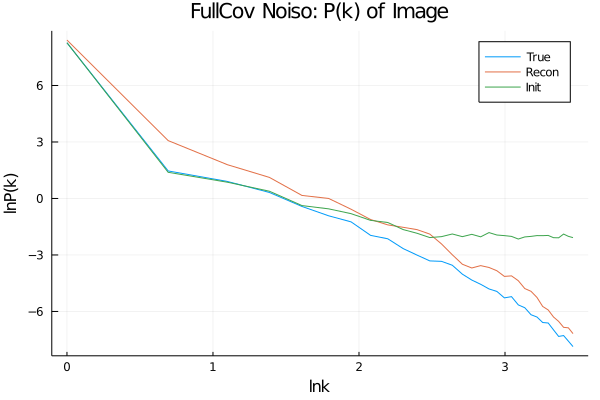

In [40]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [41]:
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...))
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...))
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...))
s_smooth = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...))


1192-element Array{Float64,1}:
  -3.144031877784822
 -10.936546358015779
  -7.175948729949612
  -6.912069606541453
  -5.762511716584831
  -6.473896463693209
  -7.078632506472145
  -6.508813780032913
  -6.249305700008489
  -6.489125133947129
  -7.28006147739092
  -6.231527617295995
  -6.098724517252059
   ⋮
  -6.744409380148002
  -7.069597157118807
  -7.194831270753814
  -6.914446623549263
  -7.1622296921050195
  -7.55984535041072
  -7.280098569358903
  -7.075231305945022
  -6.946044616955598
  -7.293234714166373
  -2.855862523646302
  -6.88024988022421

In [42]:
struesel = s_true[JS1ind]
sinitsel = s_init[JS1ind]
sreconsel = s_recon[JS1ind]
ssmoothsel = s_smooth[JS1ind]
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap(struesel, title="True", clims=clims, c=cg),
heatmap(sinitsel, title="Init", clims=clims, c=cg),
heatmap(ssmoothsel, title="SmoothInit", clims=clims, c=cg),
heatmap(sreconsel, title="Recon", clims=clims, c=cg),
heatmap(meansel, title="SFDTargMean", clims=clims, c=cg),
heatmap(sfdmed, title="SFDTargMedian", clims=clims, c=cg), size=(900, 600))

LoadError: UndefVarError: JS1ind not defined

In [43]:
clims=(-1.0, 1.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap((sinitsel .- struesel)./sigsel, title="Z Score: Init-True", clims=clims, c=cg),
heatmap((ssmoothsel .- struesel)./sigsel, title="Z Score: SmoothInit-True", clims=clims, c=cg),
heatmap((sreconsel .- struesel)./sigsel, title="Z Score: Recon-True", clims=clims, c=cg),
heatmap((meansel .- struesel)./sigsel, title="Z Score: SFDTargMean-True", clims=clims, c=cg),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean", clims=clims, c=cg),
heatmap((sfdmed .- struesel)./sigsel, title="Z Score: SFDTargMedian - True", clims=clims, c=cg), size=(900, 600))

LoadError: UndefVarError: sinitsel not defined

### Why are the zscores so high? 
Figured out: the zscores themselves aren't abnormal -- you were just using the diagonal of the inverse full covariance matrix and that's WRONG. Diagonal of inverse is NOT the variance.

In [44]:
datdir = "../../StandardizedExp/Nx64/Data_"
for f in [1, 10, 100, 1000, 10000]
    s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
end

In [45]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_10_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.8924165728318676
Init388.091139523465
0.0
Recon7.196722678076889
1.1711584235470576


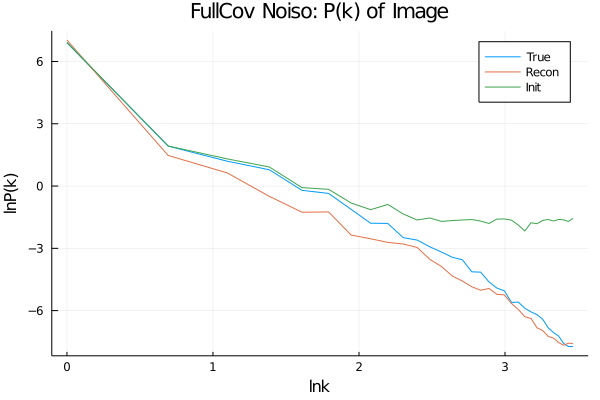

In [46]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

### Log Img's Coeffs

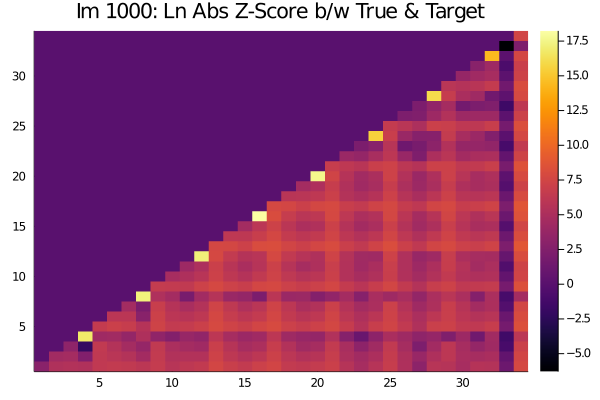

In [47]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/log_apd_noiso/1000_fullcov_triu"

gttarget = load(fname*".jld2")
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false,  :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(log.(gttarget["true_img"]))
alinit = apodizer(log.(gttarget["init"]))
alrecon = apodizer(log.(gttarget["recon"]))

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(log.(gttarget["true_img"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(log.(gttarget["init"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(log.(gttarget["recon"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
#446, 84503

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
#6e9, 0

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
#2.5e3, 6e4

ztrue_recon = (s_recon - s_true) .* diag(s_targ_invcov)
ztrue_target = (s_true - s_targ_mean) .* diag(s_targ_invcov)
zinit_target = (s_init - s_targ_mean) .* diag(s_targ_invcov)

scatter(log.(abs.(zinit_target)), log.(abs.(ztrue_recon)))
xlabel!("ln Abs Z score: Coeffs Target-Init")
ylabel!("ln Abs Z score: Coeffs Recon-True")

zscoremat = zeros(34, 34)
zscoremat[reshape(gttarget["coeff_mask"][3+34:end], (34, 34))] .= log.(abs.(ztrue_target))
heatmap(zscoremat, title="Im 1000: Ln Abs Z-Score b/w True & Target")


**Tuesday, 4/13**
1. Reg case: Init is more informative for the higher coeffs. Median >> mean
2. Log coeff: Init is also more informative for the higher coeffs here. Median~ mean here.
Z score:
3. IN ALL CASES, the full covariance inv's diagonal is inconsistent (orders of magnitude off from the true inverse variance). *Fixed. See "Why are z scores so high"?*
4. Unless there are repeated samples, this must be numerical range issues: ~100 of the 595 eigenvalues are <1e-6.
5. Code bug in SVD reconstruction.
6. Point out some of the weird images -- do we want to include these?

**Wednesday, 4/14**
1. Smooth is more informative of the higher coefficients than the init. It's definitely safer to use smooth_init in the coefficient based loss, since sometimes the higher coefficients are also affected by init (eg: Example where Log Coeffs do NOT work well).
2. The L=4-5 higher values is encoded in all true, init and smooth but lost in the mean. The benefit might be to be able to remember that.
3. What does smoothing do? Decreases variations between power at different scales but retains the original patterns.

In [48]:
gttarget["fhash"]

Dict{String,Any} with 18 entries:
  "theta_value"   => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619,…
  "j_value"       => [1.0, 2.0, 3.0, 4.0]
  "psi_ind_L"     => Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1…
  "S2_iso_mat"    => …
  "Omega_index"   => 34
  "num_coeff"     => 1192
  "psi_index"     => Int32[1 5 … 25 29; 2 6 … 26 30; 3 7 … 27 31; 4 8 … 28 32]
  "J_L"           => Int32[0 0; 1 0; … ; 4 0; 4 1]
  "phi_index"     => 33
  "wd"            => [1.0, 1.0, 1.0, 2.0]
  "num_iso_coeff" => 156
  "pc"            => 1
  "fs_center_r"   => [16.0, 8.0, 4.0, 2.0]
  "filt_value"    => [[0.0218325, 0.0540773, 0.0284208, 0.0284208, 0.0540773, 0…
  "wd_cutoff"     => 1
  "npix"          => 64
  "S1_iso_mat"    => …
  "filt_index"    => Array{CartesianIndex{2},1}[[CartesianIndex(2, 9), Cartesia…

In [49]:
#Checking all 10 images to be safe
filt_hash = fink_filter_hash(1, 8, nx=64, Omega=true)

Dict{String,Any} with 19 entries:
  "filt_index"    => Array{CartesianIndex{2},1}[[CartesianIndex(5, 8), Cartesia…
  "psi_ind_L"     => Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1…
  "S2_iso_mat"    => …
  "Omega_index"   => 34
  "num_coeff"     => 1192
  "psi_index"     => Int32[1 5 … 25 29; 2 6 … 26 30; 3 7 … 27 31; 4 8 … 28 32]
  "phi_index"     => 33
  "wd"            => [2.0, 2.0, 2.0, 2.0]
  "t"             => 1
  "wd_cutoff"     => 1
  "npix"          => 64
  "S1_iso_mat"    => …
  "theta_value"   => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619,…
  "J_L"           => Int32[0 0; 1 0; … ; 4 0; 4 1]
  "num_iso_coeff" => 156
  "fs_center_r"   => [16.0, 8.0, 4.0, 2.0]
  "filt_value"    => [[0.0089185, 0.0531124, 0.048333, 0.048333, 0.0531124, 0.0…
  "p"             => 2
  "j_value"       => [1.0, 2.0, 3.0, 4.0]

In [50]:
num=1000

1000

In [51]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_truebot = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...))
s_initbot = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...))
s_smoothbot = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...))
s_reconbot = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...))

1192-element Array{Float64,1}:
  -3.3914351141821504
 -10.545637944462566
  -7.177589052552278
  -6.288217340234273
  -5.718956693796892
  -6.325748428009598
  -7.120339088143373
  -6.228371477032441
  -5.667503368231648
  -5.492811677905582
  -7.144445691292695
  -6.226019227006753
  -5.59654229008543
   ⋮
  -7.01748543065207
  -6.872020546596044
  -7.441599373005976
  -7.082120328329247
  -6.9248609878454985
  -6.565128613416963
  -7.421059420364751
  -7.054811345671479
  -6.8790996266308095
  -6.728958888413241
  -3.2068545944145415
  -6.929627884689603

In [52]:
strueselbot = s_truebot[JS1ind]
sinitselbot = s_initbot[JS1ind]
ssmoothselbot = s_smoothbot[JS1ind]
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap(strueselbot, title="True", clims=clims, c=cg),
heatmap(sinitselbot, title="Init", clims=clims, c=cg),
heatmap(ssmoothselbot, title="SmoothInit", clims=clims, c=cg))

LoadError: UndefVarError: JS1ind not defined

In [53]:
fname = "../../StandardizedExp/Nx64/Data_" * string(100)
println(fname)
dat = load(fname*".jld2")
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

coeff_mask = gttarget["coeff_mask"]
ds_true = log.(DHC_compute_wrapper(dat["true_img"], gttarget["fhash"], norm=false; dhc_args...))
ds_init = log.(DHC_compute_wrapper(dat["init"], gttarget["fhash"], norm=false; dhc_args...))
ds_smooth = log.(DHC_compute_wrapper(imfilter(dat["init"], Kernel.gaussian(0.8)), gttarget["fhash"], norm=false; dhc_args...))


struesel = ds_true[JS1ind]
sinitsel = ds_init[JS1ind]
ssmoothsel = ds_smooth[JS1ind]
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
zlims = (-1.0, 1.0)
p = plot(heatmap(struesel, title="True", clims=clims, c=cg),
heatmap(sinitsel, title="Init", clims=clims, c=cg),
heatmap(ssmoothsel, title="SmoothInit", clims=clims, c=cg))

../../StandardizedExp/Nx64/Data_100


LoadError: UndefVarError: JS1ind not defined

## Getting Optimization with Only S1 right

### LogCoeff

In [54]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/S1only/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_full_eps10"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True18.71574511946675
0.008924165728318676
Init110.44358396146511
0.0
Recon0.2717108833346694
0.09097524200849058


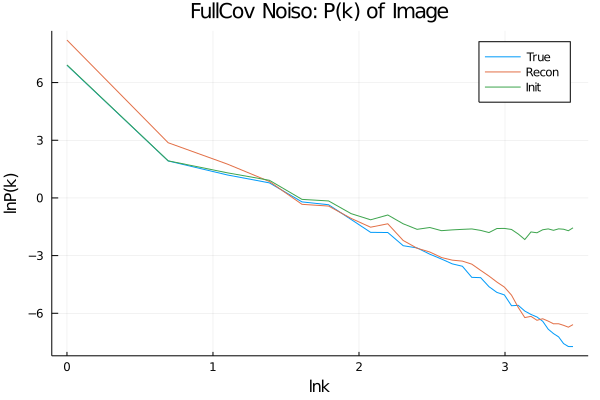

In [55]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [56]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/S1only/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_full_eps10"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True23.149541232333995
0.006638043450570209
Init107.73101221318592
0.0
Recon0.22512806853093342
0.02018479900845506


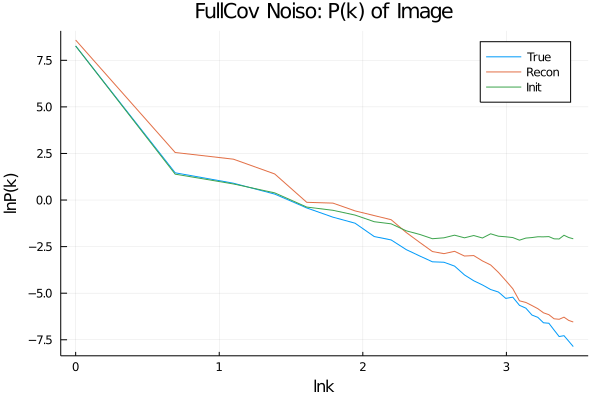

In [57]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

### 5/3
**Examining the settings of earlier runs**

In [58]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/S1only/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_full_eps10"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]

Dict{String,Any} with 18 entries:
  "theta_value"   => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619,…
  "j_value"       => [1.0, 2.0, 3.0, 4.0]
  "psi_ind_L"     => Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1…
  "S2_iso_mat"    => …
  "Omega_index"   => 34
  "num_coeff"     => 1192
  "psi_index"     => Int32[1 5 … 25 29; 2 6 … 26 30; 3 7 … 27 31; 4 8 … 28 32]
  "J_L"           => Int32[0 0; 1 0; … ; 4 0; 4 1]
  "phi_index"     => 33
  "wd"            => [1.0, 1.0, 1.0, 2.0]
  "num_iso_coeff" => 156
  "pc"            => 1
  "fs_center_r"   => [16.0, 8.0, 4.0, 2.0]
  "filt_value"    => [[0.0218325, 0.0540773, 0.0284208, 0.0284208, 0.0540773, 0…
  "wd_cutoff"     => 1
  "npix"          => 64
  "S1_iso_mat"    => …
  "filt_index"    => Array{CartesianIndex{2},1}[[CartesianIndex(2, 9), Cartesia…

In [59]:
gttarget

Dict{String,Any} with 8 entries:
  "dict"       => Dict{String,Any}("fs_targ_mean"=>[-6.42919, -5.47914, -4.9261…
  "dhc_args"   => Dict{Symbol,Bool}(:apodize=>1,:doS2=>0,:doS20=>1,:iso=>0)
  "recon"      => [0.011148 0.000226939 … 0.025887 0.030695; 0.00735475 0.01212…
  "true_img"   => [0.00765177 0.00730492 … 0.0226818 0.0233494; 0.00726517 0.00…
  "init"       => [0.011148 0.000226939 … 0.025887 0.030695; 0.00735475 0.01212…
  "trace"      => Iter     Function value   Gradient norm …
  "coeff_mask" => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0,…
  "fhash"      => Dict{String,Any}("theta_value"=>[0.0, 0.392699, 0.785398, 1.1…

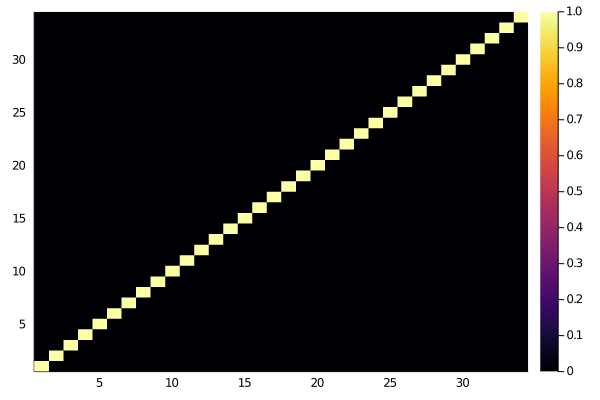

In [60]:
heatmap(reshape(gttarget["coeff_mask"][37:end], (34, 34)))

In [61]:
gttarget["dict"]

Dict{String,Any} with 15 entries:
  "fs_targ_mean"            => [-6.42919, -5.47914, -4.92615, -4.70309, -6.4325…
  "optim_settings"          => Dict{String,Any}("iterations"=>1000,"minmethod"=…
  "Invcov_matrix"           => "Full+Eps"
  "target_type"             => "sfd_dbn"
  "transform_dfunc"         => fndlog
  "lambda"                  => 0.1
  "TransformedGaussianLoss" => true
  "safemode"                => false
  "covar_type"              => "sfd_dbn"
  "GaussianLoss"            => false
  "log"                     => false
  "fs_invcov"               => [16.635 -6.13531 … -0.0666111 -5.33895; -6.13531…
  "transform_func"          => fnlog
  "datafile"                => "../Nx64/noisy_stdtrue/Data_1000.jld2"
  "fname_save"              => "../Nx64/noisy_stdtrue/S1only/SFDTargSFDCov/reg_…

In [62]:
gttarget["dict"]["fs_invcov"]

34×34 Array{Float64,2}:
 16.635      -6.13531     0.0877932    -0.347628   …  -0.0666111  -5.33895
 -6.13531    14.7986     -2.30065       0.563736      -0.178674    1.65463
  0.0877932  -2.30065     5.8992       -0.54858       -0.11458     0.0552522
 -0.347628    0.563736   -0.54858      18.6849         0.1496      0.684392
 -5.4976      1.23761     0.056248     -0.112788      -0.13446    -6.00254
  1.20895    -5.96477     0.109208     -0.0400275  …  -0.208147    1.8135
 -0.0239855   0.180604   -2.20643      -0.420169      -0.137427   -0.211169
  0.262862   -0.327715   -0.143954    -18.2605        -0.426764   -0.804897
  1.42485    -0.653737    0.0309913    -0.332783      -0.260438   -6.23055
 -0.65295     1.82197     0.115261      0.295398      -0.12429     1.98481
  0.112152   -0.101523    0.46283      -0.310631   …  -0.095476    0.262138
 -0.208708   -0.172664    0.673516     13.0917         0.147349    0.889549
  0.819854   -0.552522   -0.0221185    -0.162123      -0.116782   -6.6